<a href="https://colab.research.google.com/github/Wimmics/kgstat/blob/main/KG_and_Time_Series_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying time series analysis to meteorological data knowledge graph WeKG-MF
**beta version**

**maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)**

This notebook demonstrates how to access and query WeKG-MF RDF dataset and visualize the geographical and time series data extracted from the knowledge graph.

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions.

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo.

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.


**NOTE:**

Although this notebook closely resembles the notebook in R it does not produce exactly the same results. This is due to the data updates and the difference in the default parameters of the models used by R and Python packages.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf


In [1]:
import sys
print(sys.version_info)

colab = 'google.colab' in sys.modules
if colab:
  import google.colab
  print(f"Google Colab Version: {google.colab.__version__}")

import os
conda = os.environ.get('CONDA_DEFAULT_ENV')

if conda:
  print(f'The runtime {conda} environment is a Conda distribution')

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Google Colab Version: 0.0.1a2


## Setup


### Enabling querying of the Knowledge Graph  

In this notebook we demonstrate the use of [Corese-library with Python](https://github.com/Wimmics/corese/blob/master/docs/corese-python/Corese-library%20with%20Python.md) which is a Python wrapper of CORESE Java library.

**CORESE (COnceptual REsource Search Engine)** is a software platform implementing and extending the standards of the Semantic Web. It allows to create, manipulate, parse, serialize, query, reason, and validate RDF data. A detailed description of the CORESE software can be found [here](https://github.com/Wimmics/corese).

To enable the use of CORESE library the VM that runs this notebook has to have Java installed and the library has to be downloaded to a location accessible by this notebook.

In [2]:
!java --version

openjdk 11.0.21 2023-10-17
OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


#### Download CORESE library

The CORESE library is in development and maybe updated often. Refer to the [documetation](https://github.com/Wimmics/corese/blob/master/docs/corese-python/Corese-library%20with%20Python.md) for the latest version and isntructions.

In [3]:
import os

corese_latest = 'corese-library-python-4.5.0.jar'

if not os.path.exists(corese_latest):
  #!wget "http://files.inria.fr/corese/distrib/corese-library-python-4.4.1.jar" -P "/content/drive/My Drive/KG+Python"
  !curl "http://files.inria.fr/corese/distrib/{corese_latest}" -o "{corese_latest}"
else:
  print("CORESE is already downloaded")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.0M  100 27.0M    0     0  10.0M      0  0:00:02  0:00:02 --:--:-- 10.1M


#### Launch CORESE engine

In [4]:
  if conda:
    !conda install conda-forge::py4j
  else:
    !pip install py4j

In [5]:
import atexit
import subprocess
from time import sleep
from io import StringIO

from py4j.java_gateway import JavaGateway

# Start java gateway

java_process = subprocess.Popen(
      ['java', '-jar', '-Dfile.encoding=UTF-8', corese_latest])

sleep(1)

gateway = JavaGateway()

sleep(3)

# Stop java gateway at the enf od script
def exit_handler():
    gateway.shutdown()
    print('\n' * 2)
    print('Gateway Server Stopped')

atexit.register(exit_handler)

<function __main__.exit_handler()>

#### Define the dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [6]:
endpoint = 'https://weakg.i3s.unice.fr/sparql'

#### Define prefixes to abbreviate namespaces



In [7]:
sparql_prefix = '''
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX wdt:  <http://www.wikidata.org/prop/direct/>
PREFIX wd:   <http://www.wikidata.org/entity/>
PREFIX geosparql:  <http://www.opengis.net/ont/geosparql#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX wekg:  <http://ns.inria.fr/meteo/>
PREFIX weo: <http://ns.inria.fr/meteo/ontology/>
PREFIX wep: <http://ns.inria.fr/meteo/ontology/property/>
PREFIX wevp: <http://ns.inria.fr/meteo/vocab/weatherproperty/>
PREFIX wes-dimension: <http://ns.inria.fr/meteo/observationslice/dimension#>
PREFIX wes-measure: <http://ns.inria.fr/meteo/observationslice/measure#>
PREFIX wes-attribute: <http://ns.inria.fr/meteo/observationslice/attribute#>
PREFIX wevp-agro: <http://ns.inria.fr/meteo/vocab/agroclimatic/growingDegreeDay>

PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>

# returned data prefixes
PREFIX qudtu: <http://qudt.org/vocab/unit/>
PREFIX wd:    <http://www.wikidata.org/entity/>
PREFIX wdt:   <http://www.wikidata.org/prop/direct/>
PREFIX wes:   <http://ns.inria.fr/meteo/weatherstation/>

'''

#### Define helper functions

In [8]:
import pandas as pd
# Import classes
Graph = gateway.jvm.fr.inria.corese.core.Graph
Load = gateway.jvm.fr.inria.corese.core.load.Load
Transformer = gateway.jvm.fr.inria.corese.core.transform.Transformer
QueryProcess = gateway.jvm.fr.inria.corese.core.query.QueryProcess
RDF = gateway.jvm.fr.inria.corese.core.logic.RDF
RDFS = gateway.jvm.fr.inria.corese.core.logic.RDFS
ResultFormat = gateway.jvm.fr.inria.corese.core.print.ResultFormat
Transformer = gateway.jvm.fr.inria.corese.core.transform.Transformer

# Run query and convert the output to a DataFrame
def sparqlQuery(graph, prefixes, query, dtypes=None):
    exec = QueryProcess.create(graph)
    map = exec.query('\n'.join([prefixes, query]) )

    resultFormat = ResultFormat.create(map, ResultFormat.SPARQL_RESULTS_CSV)
    df = pd.read_csv(StringIO(resultFormat.toString()),
                     skipinitialspace=True,
                     dtype=dtypes)

    # Assign n/a to empty strings
    string_dtypes = df.convert_dtypes().select_dtypes("string")
    df[string_dtypes.columns] = string_dtypes.replace(r'^\s*$', None, regex=True)

    return df

### Enabling visualization tools

For charting the data we will be using packages:
- `matplotlib` - generates plots, histograms, bar charts, errorcharts, scatterplots, etc., with just a few lines of code
- `seaborn` - data visualization library based on matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics
- `folium` - makes it easy to visualize data on an  interactive `leaflet` map



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%%capture --no-display
if conda:
  !conda install conda-forge::basemap
else:
  !pip install basemap

### Enabling time series analysis tools
To accomplish the time series analysis of temperature data the following packages will be used:

- `pandas` - contains extensive capabilities and features for working with time series data
- `statsmodels.tsa` - is a part of the `statsmodel` package containing model classes and functions that are useful for time series analysis.
- `pmdarima` - a statistical library that implements `auto_arima` functionality and other time series analysis capabilities
- `scikit-learn` - simple and efficient tools for predictive analysis


In [11]:
import pandas as pd
import numpy as np
import statsmodels.tsa

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

In [12]:
%%capture --no-display
if conda:
  !conda install conda-forge::pmdarima
else:
  !pip install pmdarima

Commonly used metrics for evaluating time series forecasting models include:

- *Mean Absolute Error (MAE)*: measures the average absolute difference between the predicted values and the actual values. It provides a measure of the average magnitude of errors without considering their direction.

- *Mean Squared Error (MSE)*: calculates the average of the squared differences between the predicted values and the actual values. It penalizes larger errors more than MAE, making it sensitive to outliers.

- *Root Mean Squared Error (RMSE)*: is the square root of the MSE. It provides a measure of the average magnitude of errors in the same units as the original data.

- *Mean Absolute Percentage Error (MAPE)*: calculates the average percentage difference between the predicted values and the actual values. It measures the relative accuracy of the forecast and is particularly useful when comparing forecasts across different time series with varying scales.

We define a helper function that calculates them all as well as a funciton calculating the prediction confidence interval that is used in the visualization.

In [13]:
def forecast_metrics(actual, forecast, to_print=False):
  from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

  # Calculating accuracy metrics
  mae = mean_absolute_error(actual, forecast)
  mse = mean_squared_error(actual, forecast)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(actual, forecast)

  if to_print:
    print(f'Mean Absolute Error (MSA): {mae:.4f}')
    print(f'Mean Squared Error (MSE):  {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')

  return   mae, mse, rmse, mape

# Calculate confidence intervals
def forecast_conf_interval(actual, forecast, ci_level=0.95):
  from scipy.stats import norm
  import numpy as np

  residuals = actual - forecast

  # Assuming normal distribution of residuals
  z_score = norm.ppf(1 - (1 - ci_level) / 2)# 1.96 for ci_level = 0.95
  std_residuals = np.std(residuals)
  n = len(actual)

  margin_error = z_score * (std_residuals / np.sqrt(n))
  lower_ci = forecast - margin_error
  upper_ci = forecast + margin_error

  return lower_ci, upper_ci

The setup is done.

## Visualizing weather stations' locations
The WeKG dataset has information about the location of the weather stations.

Let's query the knowledge graph for the list of weather stations, their geographical coordinates, and administrative regions.

In [14]:
query_stations = f'''
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT distinct ?regionCode ?region
                ?regionLabel
                ?station ?stationName
                ?lat ?long

WHERE {{
  SERVICE <{endpoint}>
  {{
        ?station  a weo:WeatherStation;
                  rdfs:label ?stationName;
                  geo:lat ?lat; geo:long ?long.

         OPTIONAL {{?station dct:spatial/wdt:P131 ?region.
                   ?region rdfs:label ?regionLabel;
                           wdt:P2585 ?regionCode.}}
  }}
}}
ORDER BY ?regionCode ?stationName
'''
graph = Graph()

stations_df = sparqlQuery(graph, sparql_prefix, query_stations)

stations_df.shape

(61, 7)

Visualize the results on the map.

In [15]:
import folium
plt.figure(figsize=(12,5))

map = folium.Map(min_zoom=2, #max_zoom=2,
                        zoom_control=True, scrollWheelZoom=False,
                        width='95%', height='95%',
                        tile='CartoDB Positron',
                        max_bounds=True  )
for index, row in stations_df.iterrows():
    #popup_content = f"<p>{row.stationName}</p><button onclick=\"copyToClipboard('{row.stationName}')\">Select</button>"
    folium.Marker([row.lat, row.long],
                  popup=row.stationName, #popup_content
                  icon=folium.Icon(color='blue')).add_to(map)

#map.get_root().header.add_child(folium.Element(f'<script>{copy_to_clipboard_function}</script>'))

print('Click on a marker to reveal the weather sttaion name...')
map


Click on a marker to reveal the weather sttaion name...


<Figure size 1200x500 with 0 Axes>

In [16]:
#ingridients to try to make the selection of
# but it's not trivial to make it working
# the problem is the pyperclip
#!pip install pyperclip

import pyperclip

copy_to_clipboard_function = '''
function copyToClipboard(text) {
    navigator.clipboard.writeText(text);
}
'''

#popup_content = f"<p>{row.stationName}</p><button onclick=\"copyToClipboard('{row.stationName}')\">Select</button>"

#m.get_root().header.add_child(folium.Element(f'<script>{copy_to_clipboard_function}</script>'))

#pyperclip.paste()

## Plotting Average Monthly Temperatures

The WeKG-MF dataset contains calculated minimum, maximum and average daily temperatures.

We can take advantage of the already aggregated daily temperatures and aggregate them further in a SPARQL query to obtain monthly temperatures and visualize the average monthly temperatures for a weather station.

In [17]:
station_name = 'NICE'
station_name = station_name.upper()

In [18]:
query_monthly_temps = f'''
SELECT ?stationName
       ?month
       (AVG(?temp_avg) as ?avg)
       (AVG(?temp_min) as ?low)
       (AVG(?temp_max) as ?high)

WHERE
{{
  SERVICE <{endpoint}>
  {{
    VALUES (?stationName) {{ ("{station_name}") }}
    ?stationIRI rdfs:label ?stationName.

    ?s a qb:Slice ;
      wes-dimension:station ?stationIRI ;
      wes-dimension:year ?year;
      qb:observation [a qb:Observation ;
                      wes-attribute:observationDate ?date ;
                      wes-measure:avgDailyTemperature ?temp_avg;
                      wes-measure:minDailyTemperature ?temp_min;
                      wes-measure:maxDailyTemperature ?temp_max] .

    BIND(MONTH(?date) as ?month)
  }}
}}
GROUP BY ?month ?stationIRI ?stationName
ORDER BY ?month
'''

graph_temps = Graph()

monthly_temps_df = sparqlQuery(graph_temps, sparql_prefix, query_monthly_temps)

monthly_temps_df.shape

(12, 5)

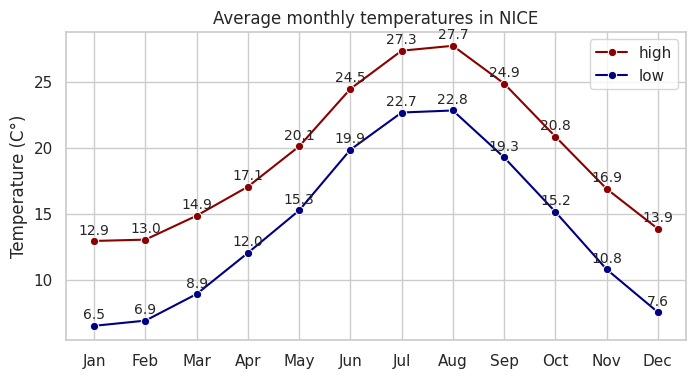

In [19]:
plt.figure(figsize=(8, 4))
sns.set_theme(style='whitegrid')

# Plot the temparaturechart
sns.lineplot(data=monthly_temps_df.loc[:, ['month', 'high', 'low']].melt('month'),
              x='month',
              y= 'value',
              hue='variable',
              palette={'high': 'darkred', 'low': 'navy'},
              marker='o')


# Add labels
for i, row in monthly_temps_df.iterrows():
    plt.text(row.month, row.high + 0.3, f'{row.high:.1f}',
             va='bottom', ha='center', size=10)
    plt.text(row.month, row.low + 0.3, f'{row.low:.1f}',
             va='bottom', ha='center', size=10)

plt.title(f'Average monthly temperatures in {station_name}')
plt.xlabel('')
plt.ylabel('Temperature (C°)')

# Set x-axis ticks to month abbreviations
import calendar
plt.xticks(ticks=monthly_temps_df.month,
           labels = [calendar.month_name[m][:3] for m in monthly_temps_df.month])

plt.legend()
plt.show()

## Are the temperatures really rising?


To answer this question we need the time series analysis tools like Time Series Decomposition and daily temperature data from the WeKG dataset for a weather station.

In [20]:
station_name= 'NICE'
station_name = station_name.upper()

In [120]:
query_daily_temps = f'''
SELECT ?station ?stationName
       ?date
       ?temp_avg
       ?temp_min
       ?temp_max

WHERE
{{
  SERVICE <{endpoint}>
  {{
    VALUES (?stationName) {{ ("{station_name}") }}
    ?station rdfs:label ?stationName.

    ?s a qb:Slice ;
            wes-dimension:station ?station ;
            qb:observation [ a qb:Observation ;
            wes-attribute:observationDate ?date ;
            wes-measure:avgDailyTemperature ?temp_avg;
            wes-measure:minDailyTemperature ?temp_min;
            wes-measure:maxDailyTemperature ?temp_max] .

    # uncomment if percipitation data is needed
    #     ?obs a weo:MeteorologicalObservation;
    #            sosa:observedProperty wevp:precipitationAmount;
    #            sosa:hasSimpleResult ?vp;
    #            sosa:phenomenonTime [ a weo:Interval3h ];
    #            sosa:resultTime ?datetime;
    #            wep:madeByStation ?station.
    #      FILTER  ( xsd:date(SUBSTR(STR(?datetime), 1,10)) =  ?date)
  }}
}}

GROUP BY ?station ?stationName ?date
ORDER BY ?date
'''
graph_temps = Graph()

daily_temps_df = sparqlQuery(graph_temps, sparql_prefix, query_daily_temps)

daily_temps_df.shape

(4018, 6)

### Convert Data Frame to a Time Series object
A time series is "a set of data collected sequentially usually at fixed intervals of time" (Merriam-Webster 2021). Time series data has characteristics that make it very useful for analyzing phenomena that change over time.

For a `pandas.DataFrame`, all it takes to create a time series is to create an index that contains the date.

In [125]:
daily_temps_df.date = pd.to_datetime(daily_temps_df.date)

daily_temps_df.set_index('date', inplace=True)
daily_temps_df.index.freq = 'D'

#daily_temps_df.info()

# Print the values statistics
pd.set_option('display.precision', 2)
daily_temps_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp_avg,4018.0,16.78,5.93,2.2,11.6,16.05,21.95,30.6
temp_min,4018.0,14.02,6.28,-1.2,8.6,13.50,19.30,28.7
temp_max,4018.0,19.53,5.73,3.1,14.7,18.90,24.70,36.5


### Time Series Decomposition
Time series decomposition separate a time series into three fundamental components that can be added together to create the original data:

- a seasonal component
- a long-term trend component
- a random component

When using historical data to anticipate what might happen in the future, we often wish to separates the seasonal and random components to see the long term historical trends.

We use Seasonal-Trend decomposition using LOESS (STL) to decompose the high and low dayily temperatures  time series. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components.

<Figure size 800x800 with 0 Axes>

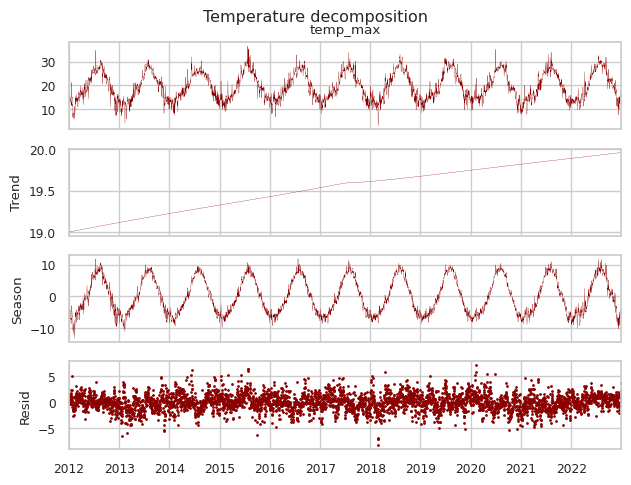

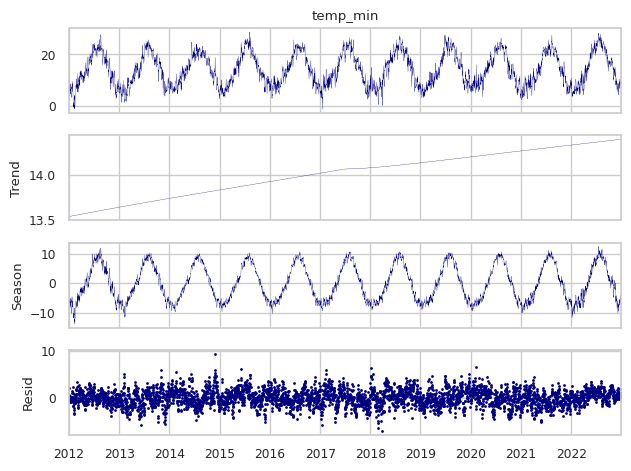

In [24]:
from statsmodels.tsa.seasonal import STL

fig = plt.figure(figsize=(8, 8))

colors = {'high': 'darkred', 'low': 'navy'}

sns.set_theme(style='whitegrid', font_scale=0.8,
              palette=colors.values(),
              rc= {'lines.linewidth': 0.2,
                   'lines.markersize' : 1})

trend_period = (daily_temps_df.index.max() - daily_temps_df.index.min() ).days

stl_max = STL(daily_temps_df.temp_max, period=365, trend=trend_period)

decomposition_max = stl_max.fit()
decomposition_max.plot().suptitle( 'Temperature decomposition', y=1.0)

#TODO: find a way to change the olor without repeating the entire theme
sns.set_theme(style='whitegrid', font_scale=0.8, palette=[colors['low']],
              rc= {'lines.linewidth': 0.2,
                   'lines.markersize' : 1})

stl_min = STL(daily_temps_df.temp_min, period=365, trend=trend_period)
decomposition_min = stl_min.fit()
decomposition_min.plot()

plt.tight_layout()
plt.show()

OBSERVATIONS AND CONCLUSIONS


---

- we can see the rising trend for both high and low temperatures in Nice.
- we can definetely see the seasonal change in temperatures in Nice.  

NOTE: you can try another station data and the trend and seasonal can be very different.

## Forecasting

Forecasting is the process of making predictions or estimates about future outcomes, or trends based on historical data, patterns, and relationships.

To demostrate forecasting let's take the daily temperatures for the a period from 2016 through 2022 for simplicity and visualization sake.

In [127]:
# Create monthly data from daily data
ts_data = daily_temps_df.temp_avg.resample('M', label='left').max()
ts_data = ts_data['2016-01-01' : '2022-12-31' ]

# Split into training and test data
training_data_monthly = ts_data.head(ts_data.shape[0] - 12)
test_data_monthly = ts_data.tail(12)

### Forecasting monthly temperatures with Holt-Winters forecast
To forecast future temperatures based on historical observations, we can use [Holt-Winters](https://otexts.com/fpp2/holt-winters.html) model that considers past seasonal cycles, trends, and random variation.

- We first create training data consisting of a time series of high temperatures aggregated by month.
- The parameters of the hw() modeling function are the time series and the number of additional observations to forecast. h=12 indicates modeling one year into the future.
- We calculate the test accuracy of the model after re-fitting on the training data only.

It is a quick method but it only uses seasonal and trend components.

In [126]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_tmax = ExponentialSmoothing(training_data_monthly,
                                  seasonal='additive',
                                  seasonal_periods=12).fit()

forecast_monthly = model_tmax.forecast(test_data_monthly.shape[0])

ci = forecast_conf_interval(test_data_monthly, forecast_monthly)
mae, mse, rmse, mape = forecast_metrics(test_data_monthly, forecast_monthly)

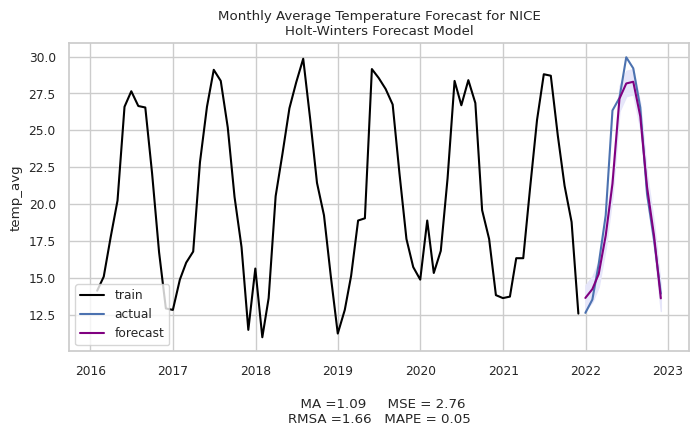

In [119]:
plt.figure(figsize=(8, 4))
sns.set_theme(style='whitegrid', font_scale=0.8)

sns.lineplot(training_data_monthly, color='black', legend=True, label='train')
sns.lineplot(test_data_monthly, legend=True, label='actual')
sns.lineplot(forecast_monthly , color='purple', legend=True, label='forecast')
plt.fill_between(test_data_monthly.index, ci[0], ci[1], color='lavender')

plt.title(f'Monthly Average Temperature Forecast for {station_name}\nHolt-Winters Forecast Model')

plt.xlabel(f'\n  MA ={mae:.2f}     MSE = {mse:.2f}' +
           f'\nRMSA ={rmse:.2f}   MAPE = {mape:.2f}',   ha='center')

plt.show()

OBSERVATIONS AND CONCLUSIONS:

---

- by looking at the Monthly Temperature chart we can observe that the forecast is pretty close to the reality especially for the spring and fall months
- in average the forecast is 1 degre off
- the Holt-Winters model forecast's MAPE is ~5%. Not too bad



---



### Forecasting monthly temperatures with Seasonal ARIMA (auto-arima)

Auto Regressive Integrated Moving Mverage ([ARIMA]( https://otexts.com/fpp2/arima.html) ) modeling involves a detailed analysis of the training data using lags and lagged forecast errors.

- *AutoRegression (AR)*: specific type of regression model where, the dependent variable depends on past values of itself (lags)

- *Integrated (I)*: this component involves differencing the time series data to make it stationary (mean and variance remain constant over time). Differencing means subtracting the previous value from the current value to remove trends or seasonality and predicting the difference.

- *Moving Average (MA)*: hhis model works by analyzing how wrong you were in predicting values for the previous time periods to make a better estimate for the current time period.

ARIMA model is described by 3 parameters (p, d, q):
  -  p - number of time lags (AR)
  -  d - order of differencing (I)
  -  q - size of moving average window (MA)

*Seasonal ARIMA* is an extension of the ARIMA model that includes seasonal components to handle time series data with seasonal patterns. It is particularly useful for modeling and forecasting time series with monthly, quarterly, or yearly patterns.

Seasonal ARIMA is represented with additional 4 parameters:
 - P - seasonal lag order (SAR)
 - D - order of differencing for the seasonal part (SI)
 - Q - number of seasonal moving average terms (SMA)
 - s - seasonal period, indicating the length of the seasonal cycle (e.g., 12 for monthly data, 4 for quarterly)

For example: SARIMA(3, 1, 1)(2, 0, 1, 12) is the model that takes into consideration 3 previous data points, has a differencing component, and considers the prediction error of the previous month's estimation. In addition it includes the seasonal pattern over 12 months, considering data from 2 previous years and that prediction error of the previous month's estimation.  

To find out the optimal combination of these parameters we can call an `auto_arima` function that would do the iteration for us based on the best `AIC` or `BIC` metrics.

- AIC - Akaike Information Criterion - estimates the quality of the model based on errors and simplicity (less is better)
- BIC - Bayesian Information Criterion - like AIC but with a havier penalty for complexity (less is better)

In [28]:
from pmdarima import auto_arima

arima_monthly = auto_arima( y=training_data_monthly,
                            start_p=1,  max_p=3,
                            d=1, max_d=2,
                            start_q=1,  max_q=3,
                            seasonal=True, m=12,
                            start_P=0, max_P=2,
                            D=0, max_D=2,
                            start_Q=0, max_Q=2,
                            information_criterion = 'aic', # (‘aic’, ‘bic’, ‘hqic’, ‘oob’)
                            trace=False,
                            #error_action='ignore',  # don't want to know if an order does not work
                            #suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True,
                            random_state=42)

arima_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -134.143
Date:                            Mon, 19 Feb 2024   AIC                            278.286
Time:                                    13:59:22   BIC                            288.673
Sample:                                01-31-2016   HQIC                           282.341
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.516e-05      0.000      0.122      0.903      -0.000       0.000
ma.L1         -0.9836      0.672     -1.464      0.143      -2.300       0.333
ar.S.L12       0.9980      0.017     59.857      0.000       0.965       1.031
ma.S.L12      -0.7907      0.780     -1.013      0.311      -2.320       0.739
sigma2         2.8098      2.901      0.969      0.333      -2.876       8.495
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.34   Prob(JB):                         0.99
Heteroskedasticity (H):               1.19   Skew:                             0.02
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
forecast_monthly = arima_monthly.predict(n_periods=12)

ci = forecast_conf_interval(test_data_monthly, forecast_monthly)

mae, mse, rmse, mape = forecast_metrics(test_data_monthly, forecast_monthly)

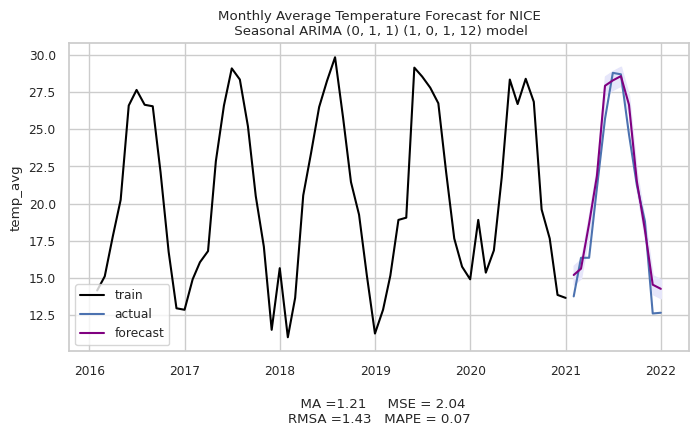

In [30]:
plt.figure(figsize=(8, 4))
sns.set_theme(style='whitegrid', font_scale=0.8)

sns.lineplot(training_data_monthly, color='black', legend=True, label='train')
sns.lineplot(test_data_monthly, legend=True, label='actual')
sns.lineplot(forecast_monthly , color='purple', legend=True, label='forecast')
plt.fill_between(test_data_monthly.index, ci[0], ci[1], color='lavender',
                 label='95% conf. int.')

arima_monthly_order = arima_monthly.get_params()['order']
arima_monthly_seasonal_order = arima_monthly.get_params()['seasonal_order']
plt.title(f'Monthly Average Temperature Forecast for {station_name}' +
          f'\n Seasonal ARIMA {arima_monthly_order} {arima_monthly_seasonal_order} model')

plt.xlabel(f'\n  MA ={mae:.2f}     MSE = {mse:.2f}' +
           f'\nRMSA ={rmse:.2f}   MAPE = {mape:.2f}',   ha='center')
plt.show()

OBSERVATIONS AND CONCLUSIONS:

- best seasonal ARIMA model for average monthly temperatures does not take into account the previous month data rather it take a previous year data for the same month (**0**, 1, 1) (**1**, 0, 1, 12)
- however it takes into account the difference in the temperatures from a previous month but not a previous year for the same month (0, **1**, 1) (1, **0**, 1, 12)
- and it takes into account the error of estimation in a previous month forecast and a previous year forecast (0, 1, **1**) (1, 0, **1**, 12)
- the metrics of ARIMA model are slightly worst than Holts-Winters forecast.

More complex models are not always the best.

### Predicting daily temperatures with ARIMA forecast

`Auto_arima` takes a lot of time and memory when applied to the daily data. In this case, we can just take the ARIMA parameters that we obtained in R notebook and fit the model with those parameters using `ARIMA` model from `statsmodels.tsa.arima.model`.

NOTE: to compare the model results with R notebook we restrict the time period from 2016 to 2021 as it was done there.

In [128]:
ts_data = daily_temps_df.temp_max['2016-01-01' : '2021-12-31' ]
ts_data.index = pd.DatetimeIndex(ts_data.index, freq='D')

# Split into training and test data
training_data_daily = ts_data.head(ts_data.shape[0] - 365)
test_data_daily = ts_data.tail(365)

In [129]:
from statsmodels.tsa.arima.model import ARIMA

arima_daily = ARIMA(training_data_daily,
                    order=(1, 0, 2), seasonal_order=(0, 1, 0, 365))\
                    .fit(method='innovations_mle', low_memory=True, cov_type='none')

arima_daily.summary()

<ipython-input-129-54e446bf2f04>:3: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  arima_daily = ARIMA(training_data_daily,


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           temp_max   No. Observations:                 2192
Model:             ARIMA(1, 0, 2)x(0, 1, [], 365)   Log Likelihood               -4133.576
Date:                            Mon, 19 Feb 2024   AIC                           8275.152
Time:                                    16:36:14   BIC                           8297.194
Sample:                                01-01-2016   HQIC                          8283.282
                                     - 12-31-2021                                         
Covariance Type:                     Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8555        nan        nan        nan         nan         nan
ma.L1         -0.3853        nan        nan        nan         nan         nan
ma.L2         -0.0741        nan        nan        nan         nan         nan
sigma2         5.4022        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               115.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.10
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [132]:
forecast_daily = arima_daily.forecast(steps=365)

ci = forecast_conf_interval(test_data_daily, forecast_daily)
mae, mse, rmse, mape = forecast_metrics(test_data_daily, forecast_daily)

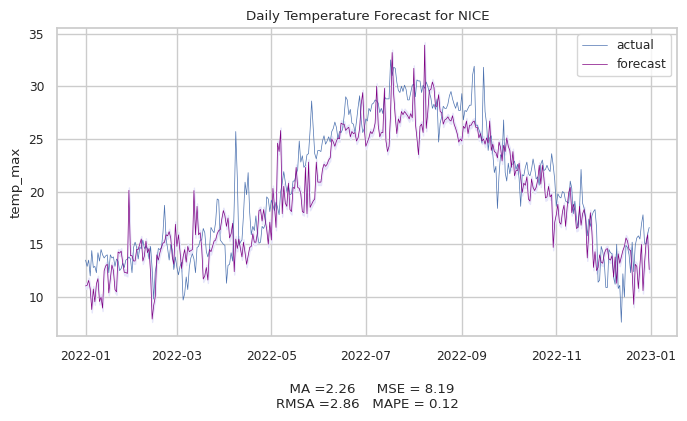

In [137]:
plt.figure(figsize=(8, 4))
sns.set_theme(style='whitegrid', font_scale=0.8, rc= {'lines.linewidth': 0.5})

#sns.lineplot(training_data_daily, color='black', legend=True, label='train')
sns.lineplot(test_data_daily, legend=True, label='actual')
sns.lineplot(forecast_daily , color='purple', legend=True, label='forecast')
plt.fill_between(test_data_daily.index, ci[0], ci[1], color='lavender',
                 label='95% conf. int.')

plt.title(f'Daily Temperature Forecast for {station_name}')
plt.xlabel(f'\n  MA ={mae:.2f}     MSE = {mse:.2f}' +
           f'\nRMSA ={rmse:.2f}   MAPE = {mape:.2f}',   ha='center')
plt.show()

In [35]:
random_dates = test_data_daily.sample(5).sort_index()

pd.concat ( [ random_dates,
              forecast_daily[random_dates.index],
              ci[0][random_dates.index].rename('ci low'),
              ci[1][random_dates.index].rename('ci high') ],
            axis=1)


,temp_max,predicted_mean,ci low,ci high
date,,,,
2021-03-14,18.6,15.6,15.32,15.88
2021-05-04,16.6,20.6,20.32,20.88
2021-07-04,25.7,26.7,26.42,26.98
2021-09-30,25.1,21.6,21.32,21.88
2021-10-20,21.1,18.2,17.92,18.48


OBSERVATIONS AND CONCLUSIONS:

---

- the forecast is off by 2 degrees on average, definitely not the best forecast
- MAPE is pretty high too but at least consistent with ~13% in  R notebook


### Regression Tree(s) for Time Series Forecasting

While scikit-learn models (e.g., Random Forest, Histogram-based Gradient Boosting Regression Tree) are not specifically designed for time series forecasting, they can still be applied to time series data, especially when combined with lagged features or other engineered features.

For  demonstration purposes we choose the following features:
- a previous day's temperature
- an average of the previous week's temperature
- a temperature one year ago.

NOTE: the `Random Forest Regressor` cannot deal with missing values we should take an extra year into consideration.

In [139]:
ts_data = daily_temps_df.temp_max['2016-01-01' : '2022-12-31' ]
ts_data.index = pd.DatetimeIndex(ts_data.index, freq='D')

ts_data_lagged = pd.concat(
              [
                  ts_data,
                  # add a previous day as predictors
                  ts_data.shift(1).rename("lagged_temp_1d"),

                  # add an average temperature for previous week
                  ts_data.shift(1).rolling(7).mean().rename("lagged_mean_1wk"),

                  # add a previous year temperature on that day
                  ts_data.shift(365).rename('lagged_temp_1y')
              ],
              axis=1)

# Dropping N/As is required for the Random Forest model
# but not for HistGradientBoostingRegressor
ts_data_lagged.dropna(inplace=True)


We demontsrate the use of `TimeSeriesSplit` object to split the time series into train and test sets.

NOTE: `TimeSeriesSplit` also helps with cross-validation splits that are not discussed here for brievity.

In [111]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit( n_splits=2,  # its a minimum we can have but we really need just one
                        test_size=365 )

train_idx, test_idx = list(ts_cv.split(ts_data_lagged))[1]

training_data_daily_X = ts_data_lagged.iloc[train_idx].drop('temp_max', axis=1)
test_data_daily_X     = ts_data_lagged.iloc[test_idx].drop('temp_max', axis=1)

training_data_daily_y = ts_data_lagged.iloc[train_idx].temp_max
test_data_daily_y     = ts_data_lagged.iloc[test_idx].temp_max

Choose a model and fit it with the training data.

In [105]:
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

regressor_daily = RandomForestRegressor().fit(training_data_daily_X, training_data_daily_y)

Make a forecast of temperatures for the last year. Compare the forecast values with actual values to evaluate the qualiy of the model.

In [107]:
forecast_daily_y = regressor_daily.predict(test_data_daily_X)
forecast_daily_y = pd.Series(forecast_daily_y,
                             index = test_data_daily_y.index)

mae, mse, rmse, mape = forecast_metrics(test_data_daily_y, forecast_daily_y)
ci = forecast_conf_interval(test_data_daily_y, forecast_daily_y)

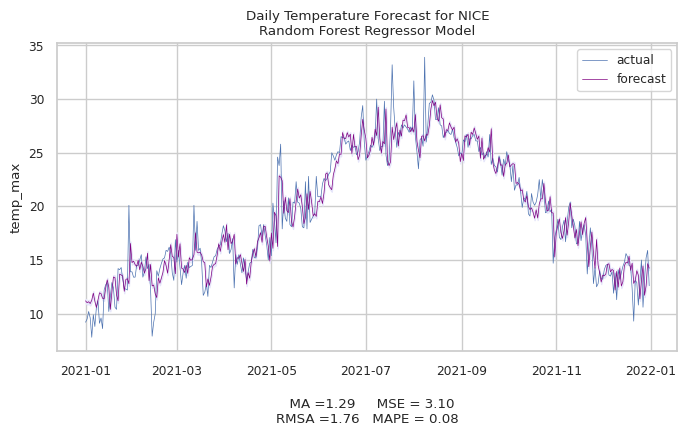

In [112]:
plt.figure(figsize=(8, 4))
sns.set_theme(style='whitegrid', font_scale=0.8, rc= {'lines.linewidth': 0.5})

sns.lineplot(test_data_daily_y, legend=True, label='actual')
sns.lineplot(forecast_daily_y , color='purple', legend=True, label='forecast')
plt.fill_between(test_data_daily_y.index, ci[0], ci[1], color='lavender',
                 label='95% conf. int.')

model =  'Random Forest Regressor Model' if isinstance(regressor_daily, RandomForestRegressor)\
         else 'Histogram-based Gradient Boosting Regression Tree Model'

plt.title(f'Daily Temperature Forecast for {station_name}' +
          f'\n{model}')
plt.xlabel(f'\n  MA ={mae:.2f}     MSE = {mse:.2f}' +
           f'\nRMSA ={rmse:.2f}   MAPE = {mape:.2f}',   ha='center')
plt.show()

OBSERVATIONS AND CONCLUSIONS:

---

- the results produced by regression models are better than ARIMAs  with 8% MAPE compart to 13%
- the fitting of the model take long time and a lot of of computing power like ARIMA

